Trial 10 Complete [00h 00m 06s]
val_loss: 0.05954431742429733

Best val_loss So Far: 0.04572690278291702
Total elapsed time: 00h 01m 04s
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
MAE SimpleRNN: 1.75
MAE LSTM: 2.94


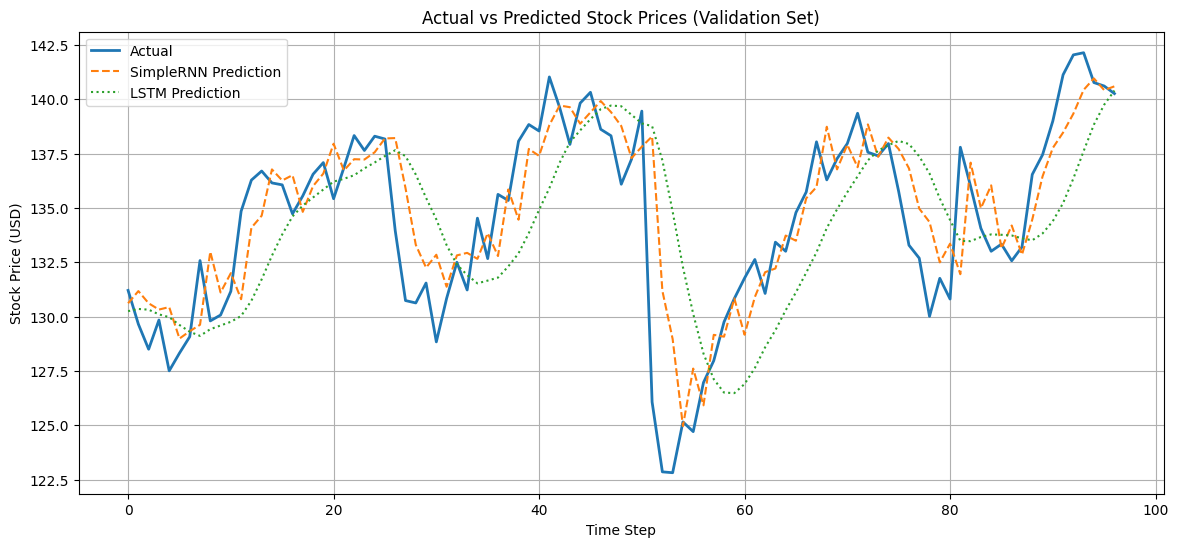

In [4]:
# نصب نسخه خاص کتابخانه yfinance
!pip install git+https://github.com/ranaroussi/yfinance.git@0.2.61
# نصب کتابخانه Keras Tuner برای بهینه‌سازی معماری مدل
!pip install keras-tuner --quiet

# ایمپورت کتابخانه‌های مورد نیاز
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# 1. دانلود داده‌های سهام گوگل از یاهو فایننس برای بازه حداقل یک‌ساله
data = yf.download("GOOG", start="2022-01-01", end="2024-01-01")

# 2. استخراج قیمت بسته‌شدن سهام (Close Price)
close_prices = data['Close'].values.reshape(-1, 1)

# 3. نرمال‌سازی داده‌ها به بازه [0, 1] برای بهبود همگرایی مدل‌های RNN/LSTM
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# 4. تبدیل سری زمانی به دنباله‌های زمانی برای مدل RNN/LSTM
# تابعی برای ایجاد ورودی‌ها و خروجی‌های دنباله‌ای با تایم‌استپ مشخص
def create_sequences(data, timestep):
    X, y = [], []
    for i in range(len(data) - timestep):
        X.append(data[i:i + timestep])    # 20 روز ورودی
        y.append(data[i + timestep])      # روز بعدی به عنوان خروجی
    return np.array(X), np.array(y)

timestep = 20  # تعداد روزهای استفاده‌شده برای پیش‌بینی
X, y = create_sequences(scaled_prices, timestep)

# 5. تقسیم داده‌ها به 80% برای آموزش و 20% برای اعتبارسنجی
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# 6. تعریف تابع ساخت مدل با لایه‌های SimpleRNN برای Keras Tuner
def build_rnn_model(hp):
    model = Sequential()
    # انتخاب تعداد لایه‌ها بین 1 تا 5 به‌صورت داینامیک
    for i in range(hp.Int("num_layers", 1, 5)):
        return_sequences = i < hp.Int("num_layers", 1, 5) - 1  # فقط لایه‌های میانی return_sequences=True
        model.add(SimpleRNN(units=hp.Int(f"units_{i}", 16, 128, step=16),
                            activation='tanh',
                            return_sequences=return_sequences,
                            input_shape=(timestep, 1)))
    model.add(Dense(1))  # لایه خروجی برای پیش‌بینی مقدار نهایی
    model.compile(optimizer="adam", loss="mae")  # استفاده از MAE به عنوان تابع خطا
    return model

# 7. استفاده از Keras Tuner برای یافتن بهترین معماری SimpleRNN
tuner_rnn = kt.RandomSearch(
    build_rnn_model,
    objective="val_loss",  # کمینه‌سازی خطای اعتبارسنجی
    max_trials=10,         # حداکثر 10 معماری متفاوت را امتحان کن
    overwrite=True,
    directory="rnn_dir",   # محل ذخیره نتایج
    project_name="rnn_opt"
)

# اجرای فرآیند جستجو برای مدل SimpleRNN
tuner_rnn.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[EarlyStopping(patience=3)])

# 8. آموزش بهترین مدل یافته‌شده توسط Tuner
best_rnn_model = tuner_rnn.get_best_models(1)[0]
rnn_pred = best_rnn_model.predict(X_val)

# 9. تعریف تابع ساخت مدل با لایه‌های LSTM برای Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 1, 5)):
        return_sequences = i < hp.Int("num_layers", 1, 5) - 1
        model.add(LSTM(units=hp.Int(f"units_{i}", 16, 128, step=16),
                       activation='tanh',
                       return_sequences=return_sequences,
                       input_shape=(timestep, 1)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mae")
    return model

# 10. استفاده از Keras Tuner برای مدل LSTM
tuner_lstm = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=10,
    overwrite=True,
    directory="lstm_dir",
    project_name="lstm_opt"
)

# اجرای فرآیند جستجو برای مدل LSTM
tuner_lstm.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[EarlyStopping(patience=3)])

# 11. آموزش بهترین مدل LSTM
best_lstm_model = tuner_lstm.get_best_models(1)[0]
lstm_pred = best_lstm_model.predict(X_val)

# 12. بازگرداندن مقادیر پیش‌بینی‌شده به مقیاس اصلی (از حالت نرمال‌شده خارج می‌کنیم)
y_val_inv = scaler.inverse_transform(y_val)
rnn_pred_inv = scaler.inverse_transform(rnn_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)

# 13. محاسبه میانگین خطای قدر مطلق (MAE) برای هر مدل
mae_rnn = mean_absolute_error(y_val_inv, rnn_pred_inv)
mae_lstm = mean_absolute_error(y_val_inv, lstm_pred_inv)

print(f"MAE SimpleRNN: {mae_rnn:.2f}")
print(f"MAE LSTM: {mae_lstm:.2f}")

# 14. ترسیم نمودار مقایسه‌ای پیش‌بینی‌ها با داده‌های واقعی
plt.figure(figsize=(14, 6))
plt.plot(y_val_inv, label="Actual", linewidth=2)
plt.plot(rnn_pred_inv, label="SimpleRNN Prediction", linestyle='--')
plt.plot(lstm_pred_inv, label="LSTM Prediction", linestyle=':')
plt.title("Actual vs Predicted Stock Prices (Validation Set)")
plt.xlabel("Time Step")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
